# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.shape

(45993, 3)

In [4]:
# Group the data by user and count the number of interactions
user_article_counts = df.groupby('email')['article_id'].count().reset_index(name='interaction_count')

In [5]:
# sort user articles in decending order
user_article_counts.sort_values(by=['interaction_count'],ascending=False, inplace=True)

In [6]:
user_article_counts.head()

,email,interaction_count
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


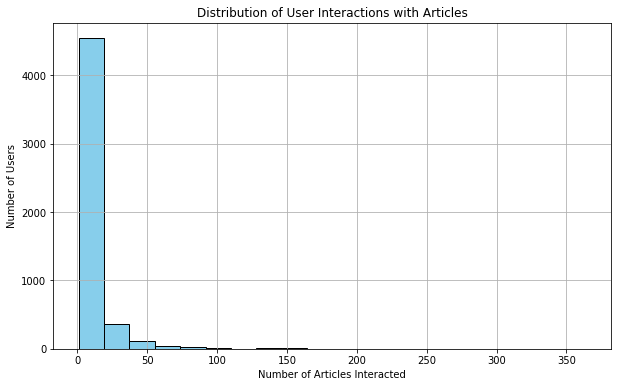

In [7]:
# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(user_article_counts['interaction_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of User Interactions with Articles')
plt.xlabel('Number of Articles Interacted')
plt.ylabel('Number of Users')
plt.grid(True)

# Show plot
plt.show()

In [8]:
# use describe to use descriptive statistics
user_article_counts.describe()

,interaction_count
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [9]:
# Fill in the median and maximum number of user_article interactios below

median_val =user_article_counts['interaction_count'].median()  # 50% of individuals interact with _3_ number of articles or fewer.
max_views_by_user = user_article_counts['interaction_count'].max() # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


In [11]:
# Remove any rows that have the same article_id
# check shape with duplicates
df_content.shape

(1056, 5)

In [12]:
# number of articles without duplicates
len(df_content['article_id'].unique())

1051

In [13]:
# remove duplicates
df_content.drop_duplicates(subset=['article_id'],inplace=True)

In [14]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
unique_articles =len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(df_content['article_id'].unique())# The number of unique articles on the IBM platform
unique_users = df['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
#create a new dataframe by grouping article id with interactions
unique_article_with_interaction =df.groupby('article_id')['email'].count().reset_index(name='interactions')

In [17]:
# sort the unique article id in descending order
unique_article_with_interaction.sort_values(by=['interactions'],ascending=False, inplace=True)

In [18]:
# display head of unique article interaction
unique_article_with_interaction.head()

,article_id,interactions
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


In [19]:
unique_article_with_interaction['article_id'] = unique_article_with_interaction['article_id'].astype(str)

In [20]:
most_viewed_article_id = unique_article_with_interaction['article_id'][:1].values # The most viewed article in the dataset as a string with one value following the decimal 
max_views = unique_article_with_interaction.max()['interactions']# The most viewed article in the dataset was viewed how many times?

In [21]:

# create a function to map the user email to a user_id column and remove the email column

def email_mapper():
    ''' 
    INPUT:
    pandas dataframe - where user email will be replaced with user_id  
    
    OUTPUT:
    pandas dataframe - with article_id, title and user_id(email mapped) 
    
    '''

    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [22]:
#test cell

print('50% of individuals have _____ or fewer interactions.: ', median_val)
print('The total number of user-article interactions in the dataset is: ',user_article_interactions)
print('The maximum number of user-article interactions by any 1 user is: ', max_views_by_user)
print('The most viewed article in the dataset was viewed _____ times', max_views)
print('The article_id of the most viewed article is: ', most_viewed_article_id)
print('The number of unique articles that have at least 1 rating: ', unique_articles)
print('The number of unique users in the dataset is: ', unique_users)
print('The number of unique articles on the IBM platform: ', total_articles)

50% of individuals have _____ or fewer interactions.:  3.0
The total number of user-article interactions in the dataset is:  45993
The maximum number of user-article interactions by any 1 user is:  364
The most viewed article in the dataset was viewed _____ times 937.0
The article_id of the most viewed article is:  ['1429.0']
The number of unique articles that have at least 1 rating:  714
The number of unique users in the dataset is:  5148
The number of unique articles on the IBM platform:  1051


In [23]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [24]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Group by article_id and count interactions for each article from dataframe(df)
    article_with_interaction =df.groupby('article_id')['user_id'].count().reset_index(name='interactions')
    
    # Sort the articles based on interaction count in descending order
    article_with_interaction.sort_values(by=['interactions'],ascending=False, inplace=True)

     # Extract the top 'n' article_id
    top_articles_id = article_with_interaction['article_id'][:n]
    
    # Get titles from df using the top 'n' article IDs
    top_articles = df.loc[df['article_id'].isin(top_articles_id), 'title'].unique().tolist()
    
    return top_articles # Return the top article titles from df 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
     # Group by article_id and count interactions for each article from dataframe(df)
    article_with_interaction =df.groupby('article_id')['user_id'].count().reset_index(name='interactions')
    
    # Sort the articles based on interaction count in descending order
    article_with_interaction.sort_values(by=['interactions'],ascending=False, inplace=True)

     # Extract the top 'n' article_id
    top_articles_id = list(article_with_interaction['article_id'][:n])
 
    return top_articles_id # Return the top article ids

In [25]:
# test functions
print(get_top_articles(4))
print(get_top_article_ids(4))

['use deep learning for image classification', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'insights from new york car accident reports']
[1429.0, 1330.0, 1431.0, 1427.0]


In [26]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [27]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # aggregation function is applied to fill 1, for articles interacted with
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [29]:
## test 
user_item.head(4)

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      0      0      1      0      0      0   
4               0      0      0      0      0      0      0      0      0   

                   ...                                                     \
article_id 18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                      
1               0  ...        0      0      1      0      1      0      0   
2               0  ...        0      0      0      0      0      0      0   
3               0  ...        0      0      1      0      0      0      0   
4               0  ...        0      0      0      0      0      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  

[4 rows x 714 columns]

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [30]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Get the vector of the provided user_id
    user_vector = user_item.loc[user_id]
    
    # compute similarity of each user to the provided user using dot product
    dot_products = {}
    for other_user_id, other_user_vector in user_item.iterrows():
        if other_user_id != user_id:
            dot_products[other_user_id]= np.dot(user_vector, other_user_vector)
            
    # sort by similarity, with top rows as most similar
    most_similar_users = sorted(dot_products.items(), key=lambda x:x[1], reverse=True)
    
    # create list of just the ids without own user id
    most_similar_user_ids = [user[0] for user in most_similar_users if user[0] != user_id]
    
       
    return most_similar_user_ids # return a list of the users in order from most to least similar
        

In [31]:
#test cell
find_similar_users(440)[:4][0]

1281

In [32]:
# test cell
type(find_similar_users(440)[:4][0])

int

In [33]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [34]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # get article name
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # get articles
    article_ids = user_item.loc[user_id][user_item.loc[user_id] > 0].index.get_level_values(level=1).astype(str).tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # compute similar users
    similar_users = find_similar_users(user_id, user_item)
    article_ids = set()
    
    # iterate to get number of articles(m)
    for similar_user in similar_users:
        similar_user_article_ids, _ = get_user_articles(similar_user)
        article_ids.update(similar_user_article_ids)
        if len(article_ids) >= m:
            break
    
    recs_article_ids = list(article_ids)[:m]
    recs = get_article_names(recs_article_ids)
    
    return recs # return your recommendations for this user_id    

In [35]:
user_user_recs(1)

['apache spark lab, part 1: basic concepts',
 'access db2 warehouse on cloud and db2 with python',
 'visualize car data with brunel',
 'gosales transactions for naive bayes model',
 'welcome to pixiedust',
 'deep learning with tensorflow course by big data university',
 'rapidly build machine learning flows with dsx',
 'uci: iris',
 'sector correlations shiny app',
 'introducing ibm watson studio ']

In [36]:
#test cell
get_article_names(['1430.0','1429.0','1276.0'])

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'use deep learning for image classification',
 'deploy your python model as a restful api']

In [37]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [38]:
## Test cell
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [39]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Get the vector of the provided user_id
    user_vector = user_item.loc[user_id]
    
    # Compute dot product of given user with all other users
            
    dot_products = {}
    for other_user_id, other_user_vector in user_item.iterrows():
        if other_user_id != user_id:
            dot_products[other_user_id]= np.dot(user_vector, other_user_vector)

   # Sort users based on dot product in descending order
    most_similar_users = sorted(dot_products.items(), key=lambda x:x[1], reverse=True)
  
   
    #convert list of tuple to dataframe with user_id and dot_product(similarity)
    most_similar_user_df= pd.DataFrame(most_similar_users, columns=['user_id', 'similarity'])
    
  
    # Get the number of interactions for each user
    num_interactions = df.groupby('user_id')['article_id'].count().reset_index(name='num_interactions')
   
    # Merge the similarity DataFrame(most_similar_user_df) with interactions DataFrame(num_interactions)
    neighbors_df = pd.merge(most_similar_user_df, num_interactions, on='user_id', how='left')
    
    # Sort neighbors_df by similarity and then by number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False], inplace=True)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get articles already seen by the user
    seen_articles = get_user_articles(user_id)[0]
    
    # Find similar users based on closeness
    similar_users = get_top_sorted_users(user_id)
    
    # Recommendations list
    recommendations = []
    
    # Loop through similar users and find articles they've interacted with but the current user hasn't
    for user in similar_users['user_id']:
        articles_seen_by_similar_user = get_user_articles(user)[0]
        for article_id in articles_seen_by_similar_user:
            if article_id not in seen_articles and article_id not in recommendations:
                recommendations.append(article_id)
                if len(recommendations) >= m:
                    break

    recs = recommendations[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [40]:
# Test cell
user_user_recs_part2(1,5)

(['2.0', '12.0', '14.0', '16.0', '26.0'],
 ['got zip code data? prep it for analytics. – ibm watson data lab – medium',
  'timeseries data analysis of iot events by using jupyter notebook',
  'this week in data science (april 18, 2017)',
  'higher-order logistic regression for large datasets',
  'using machine learning to predict parking difficulty'])

In [41]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'accelerate your workflow with dsx', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'tensorflow quick tips', 'challenges in deep learning', 'neural networks for beginners: popular types and applications', 'statistics for hackers', 'introduction to neural networks, advantages and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [42]:
### Tests with a dictionary of results

user1_most_sim = user_user_recs_part2(1,3)[0][0] # Find the user that is most similar to user 1 
user131_10th_sim = user_user_recs_part2(131,10)[0][9]# Find the 10th most similar user to user 131

In [47]:
## test
print('user that is most similar to user 1 is: ',user_user_recs_part2(1,3)[0][0])
type(user1_most_sim)

user that is most similar to user 1 is:  2.0


str

In [48]:
## test
user131_10th_sim

'76.0'

In [49]:
## test
print('The user that is most similar to user 1 is :', user1_most_sim)
print('The user that is the 10th most similar to user 131 is: ', user131_10th_sim)

The user that is most similar to user 1 is : 2.0
The user that is the 10th most similar to user 131 is:  76.0


In [ ]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim}

t.sol_5_test(sol_5_dict)


###Above function is giving me an error
TypeError                                 Traceback (most recent call last)
<ipython-input-93-62627b96aea5> in <module>()
      4     'The user that is the 10th most similar to user 131': user131_10th_sim}
      5 
----> 6 t.sol_5_test(sol_5_dict)

/workspace/home/project_tests.py in sol_5_test(sol_5_dict)
     54     else:
     55         for k, v in sol_5_dict_1.items():
---> 56             if set(sol_5_dict[k]) != set(sol_5_dict_1[k]):
     57                 print("Oops!  Looks like there is a mistake with the {} key in your dictionary.  The answer should be {}.  Try again.".format(k,v))
     58 

TypeError: 'int' object is not iterable

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

- All above funtions require a user_id and interations of some sort. So the above functions will not be useful for a new user. 
- A function that gives the best to 10/20/n articles with high interactions will be a best start. Taking the top articles with high interactions.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [50]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = unique_article_with_interaction['article_id'][:10].astype(str) # Your recommendations here



In [51]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.



In [52]:
df_content.head(4)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [54]:
#test cell
articles = df_content['doc_description']
articles[:3]

0    Detect bad readings in real time using Python ...
1    See the forest, see the trees. Here lies the c...
2    Here’s this week’s news in Data Science and Bi...
Name: doc_description, dtype: object

In [55]:
def make_content_recs(df=df_content, term='IBM Watson', n=5):
    """
    Make recommendations based on content similarity to a given term.

    Parameters:
        articles (list of str): List of article texts.
        term (str): The term to find similar articles for.
        n (int): Number of recommendations to make.

    Returns:
        list of str: Top N recommended articles.
    """
    
    # Remove NaN values from the list of articles
    articles = df_content['doc_description']
    articles = [article for article in articles if isinstance(article, str)]
    
    # Compute TF-IDF representation of articles
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(articles)

    # Compute similarity between articles and the given term
    term_vector = vectorizer.transform([term])
    similarities = cosine_similarity(tfidf_matrix, term_vector)

    # Get indices of articles sorted by similarity score
    ranked_indices = similarities.argsort(axis=0)[::-1].flatten()

    # Get top N recommended articles
    recommended_articles = [articles[idx] for idx in ranked_indices[:n]]

    return recommended_articles

In [56]:
#test cell


make_content_recs(df_content)

['Watch this video to see how to use IBM Watson Machine Learning and IBM Data Science Experience to create a data flow using IBM SPSS Modeler to predict chronic ki...',
 'This video provides an overview of IBM Data Catalog, part of Watson Data Platform. ',
 'Watch this video to see how to get started with IBM Watson Machine Learning (WML) by provisioning the necessary services in IBM Bluemix.',
 "Search your Slack account using an IBM Graph database and Watson's AlchemyAPI.",
 "Do you want to leverage Compose, Twilio, and IBM Watson to provide customers with a real-time, interactive experience? We'll show you how, on IBM Bluemix."]

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?



**An explanation of my content based recommendation system above.**

* The recommendation function take all IBM articles and searches for article that have common word( the provided term), then it returns top n articles similar to term.
* The function does the following
    * get articles from provided dataframe removing NAN if any
    * TF-IDF(Term Frequency - Inverse DocumentFrequency) is computed, it measure importance of a word to a specific document.
    * Article similarity is computed using cosine_similarity function
    * Articles are ranked according to similarity
    * Top articles will be filterd and recommended according to provided n(number of articles)

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.



In [57]:
# make recommendations for a brand new user
# five articles with Python as a term will be recommended. 
# Note that the term and number of articles can be changed on function
make_content_recs(df_content)


['Watch this video to see how to use IBM Watson Machine Learning and IBM Data Science Experience to create a data flow using IBM SPSS Modeler to predict chronic ki...',
 'This video provides an overview of IBM Data Catalog, part of Watson Data Platform. ',
 'Watch this video to see how to get started with IBM Watson Machine Learning (WML) by provisioning the necessary services in IBM Bluemix.',
 "Search your Slack account using an IBM Graph database and Watson's AlchemyAPI.",
 "Do you want to leverage Compose, Twilio, and IBM Watson to provide customers with a real-time, interactive experience? We'll show you how, on IBM Bluemix."]

### -Make a recommendations for a user who only has interacted with article id '1427.0'
* since there is some interaction with a certain article_id, it will be best to use collaborative filtering
* user_user_recs_part2(user_id, m=10) created above will suit the user.
* based on article id, find user who interacted with this article and 
* recommend otherget_user_articles by other users(user_id, user_item=user_item)

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [58]:
# quick look at the matrix
user_item.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      0      0      1      0      0      0   
4               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   

                   ...                                                     \
article_id 18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                      
1               0  ...        0      0      1      0      1      0      0   
2               0  ...        0      0      0      0      0      0      0   
3               0  ...        0      0      1      0      0      0      0   
4               0  ...        0      0      0      0      0      0      0   
5               0  ...        0      0      0      0      0      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  
5               0      0      0  

[5 rows x 714 columns]

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [59]:
# import required libraries

from scipy.linalg import svd

In [60]:
# Perform SVD on the User-Item Matrix Here


#create svd function
def perform_svd(matrix, k=None):
    """
    Perform Singular Value Decomposition (SVD) on the given matrix.

    Parameters:
        matrix (numpy.ndarray): The matrix to perform SVD on.
        k (int or None): The number of singular values and vectors to compute. 
                         If None, computes the full-rank decomposition.

    Returns:
        numpy.ndarray: The left singular vectors.
        numpy.ndarray: The singular values.
        numpy.ndarray: The right singular vectors.
    """
    # Perform SVD
    u, s, vt = np.linalg.svd(user_item, full_matrices=False)
    
    # Keep only the top k singular values and vectors if specified
    if k is not None:
        u = u[:, :k]
        s = s[:k]
        vt = vt[:k, :]
    
    return u, s, vt




In [61]:
u, s, vt = perform_svd(user_item) # use the built in to get the three matrices

In [62]:
#test cell
u,s,vt

(array([[ -4.30899801e-02,  -8.30671762e-03,  -2.75704572e-02, ...,
          -8.27795197e-03,   1.08385315e-02,  -1.03901140e-02],
        [ -1.03765691e-02,  -1.64771768e-02,  -6.04781444e-03, ...,
          -9.51038708e-03,   8.64300781e-03,   2.05118654e-02],
        [ -4.98474594e-02,  -1.44789670e-03,   1.64960631e-02, ...,
          -6.05386226e-03,  -4.16387034e-03,  -2.15838261e-02],
        ..., 
        [ -3.22580101e-05,   7.76317124e-05,  -5.55685276e-05, ...,
          -1.83929934e-03,   1.22162265e-03,  -5.84406070e-04],
        [ -2.46741942e-03,  -3.80247363e-03,   4.46702539e-03, ...,
           1.29407977e-04,   1.27027488e-03,  -1.16896634e-03],
        [ -4.91946427e-04,   1.00943223e-03,  -4.99509739e-04, ...,
          -2.35934919e-03,   8.96008576e-04,  -1.84135230e-03]]),
 array([  5.53457037e+01,   2.32486418e+01,   2.17600228e+01,
          2.06583341e+01,   1.99708867e+01,   1.95569462e+01,
          1.91632342e+01,   1.87197508e+01,   1.83438615e+01,
      

**Provide your response here.**

* it has to do with latent defects

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

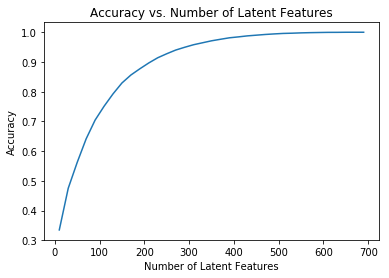

In [63]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [64]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Get unique users and articles from both datasets
    train_idx = df_train['user_id'].unique()
    train_arts = df_train['article_id'].unique()
    test_idx = df_test['user_id'].unique()
    test_arts = df_test['article_id'].unique()
    
    # Get all unique users and articles across both datasets
    all_users = np.unique(np.concatenate([train_idx, test_idx]))
    all_articles = np.unique(np.concatenate([train_arts, test_arts]))

    # Create empty matrices for training and test sets
    user_item_train = np.zeros((len(all_users), len(all_articles)))
    user_item_test = np.zeros((len(all_users), len(all_articles)))
    
    # Fill in the matrices based on interactions in the DataFrames
    for index, row in df_train.iterrows():
        user_idx = np.where(all_users == row['user_id'])[0][0]
        article_idx = np.where(all_articles == row['article_id'])[0][0]
        user_item_train[user_idx, article_idx] = 1  # Assuming binary interaction

    for index, row in df_test.iterrows():
        user_idx = np.where(all_users == row['user_id'])[0][0]
        article_idx = np.where(all_articles == row['article_id'])[0][0]
        user_item_test[user_idx, article_idx] = 1  # Assuming binary interaction
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [65]:
#test cell
len(test_arts)

574

In [66]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?':b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [67]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train =  perform_svd(user_item_train) # fit svd similar to above then use the cells below

In [68]:
# Reconstruct the user_item_train matrix using the SVD components
user_item_train_pred = np.dot(np.dot(u_train, np.diag(s_train)), vt_train)

In [69]:
# Calculate Mean Squared Error between the original and reconstructed matrices
mse_train = np.mean(np.square(user_item_train - user_item_train_pred))

In [70]:
print("Mean Squared Error on training data:", mse_train)

Mean Squared Error on training data: 0.00120172364926


In [71]:
# fit SVD on the user_item_test matrix
u_test, s_test, vt_test =  perform_svd(user_item_test)

In [72]:
# Reconstruct the user_item_train matrix using the SVD components
user_item_test_pred = np.dot(np.dot(u_train, np.diag(s_train)), vt_test)

In [73]:
# Calculate Mean Squared Error between the original and reconstructed matrices
mse_test = np.mean(np.square(user_item_test - user_item_test_pred))

In [74]:
print("Mean Squared Error on test data:", mse_test)

Mean Squared Error on test data: 0.0079526469745


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Improvements over how user get articles**
- Baseline Evaluation: Evaluate the current method users use to find articles with no the recommendation system. among other it could involve analyzing user behavior, conducting user surveys to understand how users currently interact with the platform or engagement metrics.
- A/B Testing: Conduct A/B testing to compare the performance of the recommendation system with and without SVD. Randomly assign users to different groups: one group receives recommendations from the SVD model, while the other group continues to use the current method. 
- Iterative Improvement: Continuously monitor the performance of the recommendation system and iterate on the model, algorithms, or parameters based on user feedback and evaluation results. This iterative process ensures that the recommendation system evolves to better meet the needs and preferences of users over time.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [75]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0